In [3]:
!pip install wordcloud

In [58]:
!pip install scikit-multilearn
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import nltk
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mihirupadhyay/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [6]:
print(dt.datetime.now())

2024-04-21 12:51:12.559011


In [7]:
print(df.index)

NameError: name 'df' is not defined

In [ ]:
df.head()

In [8]:
if os.path.isfile("train.db"):
    start = datetime.now()
    con = sqlite3.connect("train.db")
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else: 
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:03.645025


In [9]:
print(type(num_rows))

<class 'pandas.core.frame.DataFrame'>


In [10]:
num_rows["count(*)"].values[0]

6034196

In [11]:
if os.path.isfile("train.db"):
    start = datetime.now()
    con = sqlite3.connect("train.db")
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:05:36.016573


In [12]:
type(df_no_dup)

pandas.core.frame.DataFrame

In [13]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [14]:
print("no. of duplicate questions:", num_rows["count(*)"][0] - df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

no. of duplicate questions: 1827881 ( 30.292038906260256 % )


In [15]:
type(df_no_dup.cnt_dup.value_counts())

pandas.core.series.Series

In [100]:
df_no_dup.shape

(4206308, 5)

In [16]:
df_no_dup.cnt_dup.value_counts().sum()

4206315

In [17]:
df_no_dup.Tags

0                                        c++ c
1                  c# silverlight data-binding
2          c# silverlight data-binding columns
3                                     jsp jstl
4                                    java jdbc
                          ...                 
4206310             wordpress wordpress-plugin
4206311                         php mysql text
4206312     php codeigniter character-encoding
4206313                 php email outlook mime
4206314                                   html
Name: Tags, Length: 4206315, dtype: object

In [18]:
def words_count(text):
    if text:
        return len(text.split(" "))
    else:
        return 0

start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")) if text is not None else 0)
#df_no_dup["tag_count"] = df_no_dup["Tags"].apply(words_count)          
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:06.222238


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [19]:
df_no_dup.tag_count.value_counts()

tag_count
3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: count, dtype: int64

In [20]:
df_no_dup = df_no_dup.dropna(subset=['Tags'])

In [21]:
print(df_no_dup[df_no_dup["tag_count"] == 0].Title)

Series([], Name: Title, dtype: object)


In [22]:
if not os.path.isfile("train_no_dup.db"):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=["Title", "Body", "Tags"])
    no_dup.to_sql("no_dup_train", disk_dup)

In [23]:
if os.path.isfile("train_no_dup.db"):
    start = datetime.now()
    con = sqlite3.connect("train_no_dup.db")
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()

In [24]:
tag_data.head()

,Tags
0,c++ c
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc


In [25]:
type(tag_data)

pandas.core.frame.DataFrame

In [26]:
tag_data.index[1]

1

In [27]:
tag_data.drop(tag_data.index[0], inplace=True)

In [28]:
tag_data.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


In [29]:
tag_data.shape

(4206307, 1)

In [30]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [31]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206307
Number of unique tags : 42048


In [32]:
type(tag_dtm)

scipy.sparse._csr.csr_matrix

In [33]:
tag_dtm.shape

(4206307, 42048)

In [34]:
tags = vectorizer.get_feature_names_out()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a' '.app' '.asp.net-mvc' '.aspxauth' '.bash-profile' '.class-file'
 '.cs-file' '.doc' '.drv' '.ds-store']


In [35]:
print(tag_dtm[0].toarray())

[[0 0 0 ... 0 0 0]]


In [36]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [37]:
type(result)

dict

In [38]:
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [39]:
tag_df_sorted = tag_df.sort_values(["Counts"], ascending = False)
tag_counts = tag_df_sorted["Counts"].values
print(tag_counts)
type(tag_counts)

[331505 299414 284103 ...      1      1      1]


numpy.ndarray

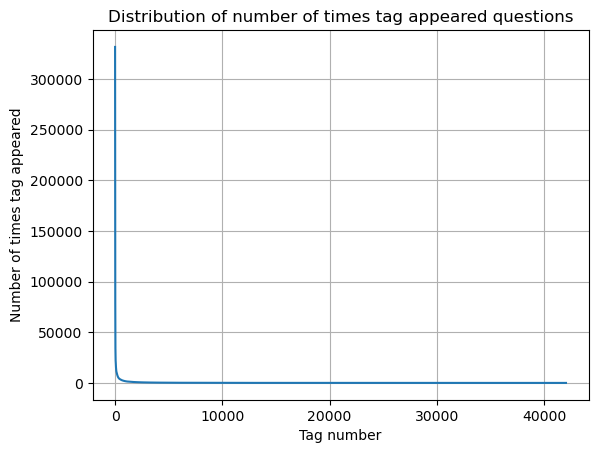

In [40]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

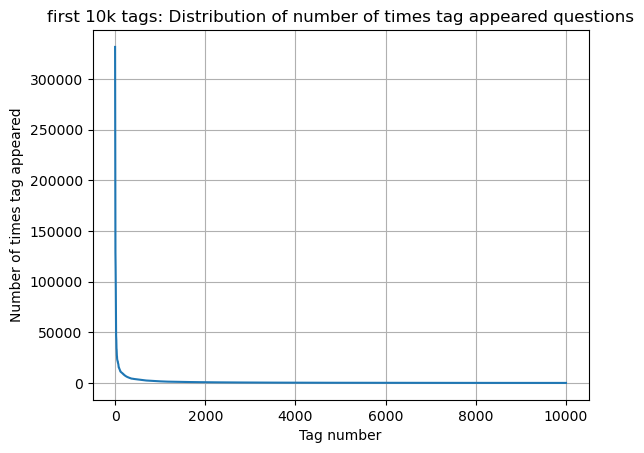

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2986   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [41]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

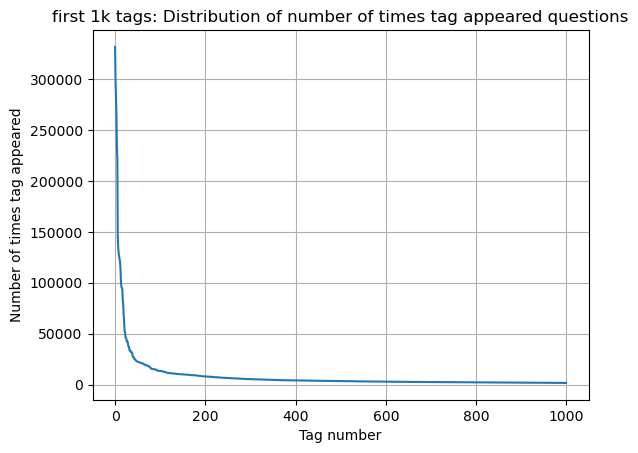

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [42]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

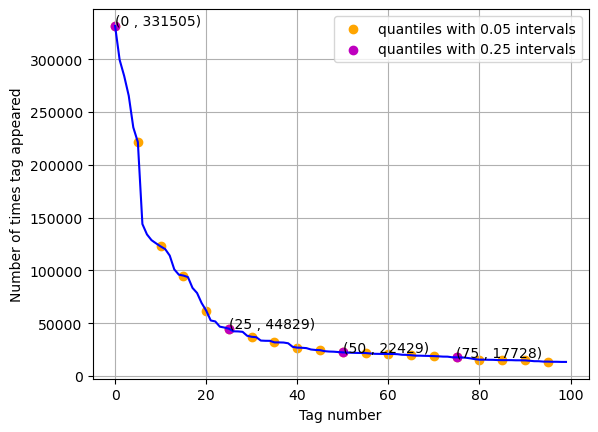

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [43]:
plt.plot(tag_counts[0:100], c = "b")
plt.scatter(x = list(range(0,100,5)), y = tag_counts[0:100:5], c = "orange", label="quantiles with 0.05 intervals")
plt.scatter(x = list(range(0,100,25)), y = tag_counts[0:100:25], c = "m", label="quantiles with 0.25 intervals" )

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))
    
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [44]:
tag_df_gt_10k = tag_df[tag_df["Counts"]>10000].Tags
tag_df_gt_10k.head()
print(type(tag_df_gt_10k))
print(len(tag_df_gt_10k))
tag_df_gt_100k = tag_df[tag_df["Counts"]> 100000].Tags
print(len(tag_df_gt_100k))
print(tag_df_gt_10k)
tag_df_gt_10k.shape
tag_df_gt_10k.index
tag_df.head()

<class 'pandas.core.series.Series'>
153
14
15            .htaccess
22                 .net
466      actionscript-3
918                ajax
1001          algorithm
              ...      
40946               wpf
41194              xaml
41245             xcode
41395               xml
41882    zend-framework
Name: Tags, Length: 153, dtype: object


,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [45]:
tag_df[tag_df["Tags"] ==  ".htaccess"].Counts

15    14884
Name: Counts, dtype: int64

In [46]:
tag_dtm.shape

(4206307, 42048)

In [47]:
tag_quest_count = tag_dtm.sum(axis = 1).tolist()
tag_quest_count_2 = []
for l in tag_quest_count:
    for j in l:
        tag_quest_count_2.append(int(j))

tag_quest_count = tag_quest_count_2[:]

#can write the above loop in short using comprehensive list
print(tag_quest_count[:5])
len(tag_quest_count)

[3, 4, 2, 2, 3]


4206307

In [48]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


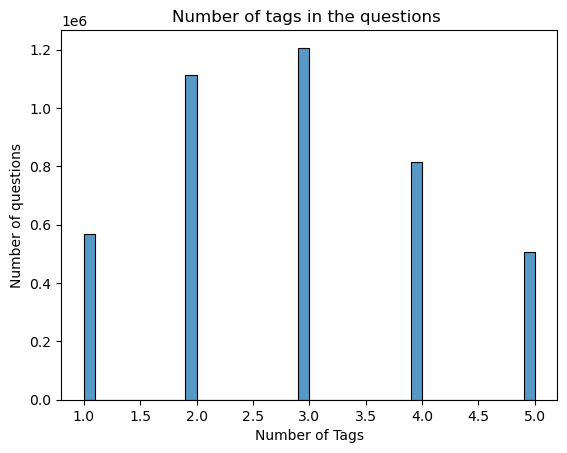

In [49]:
sns.histplot(tag_quest_count, palette='species', binwidth = 0.1)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

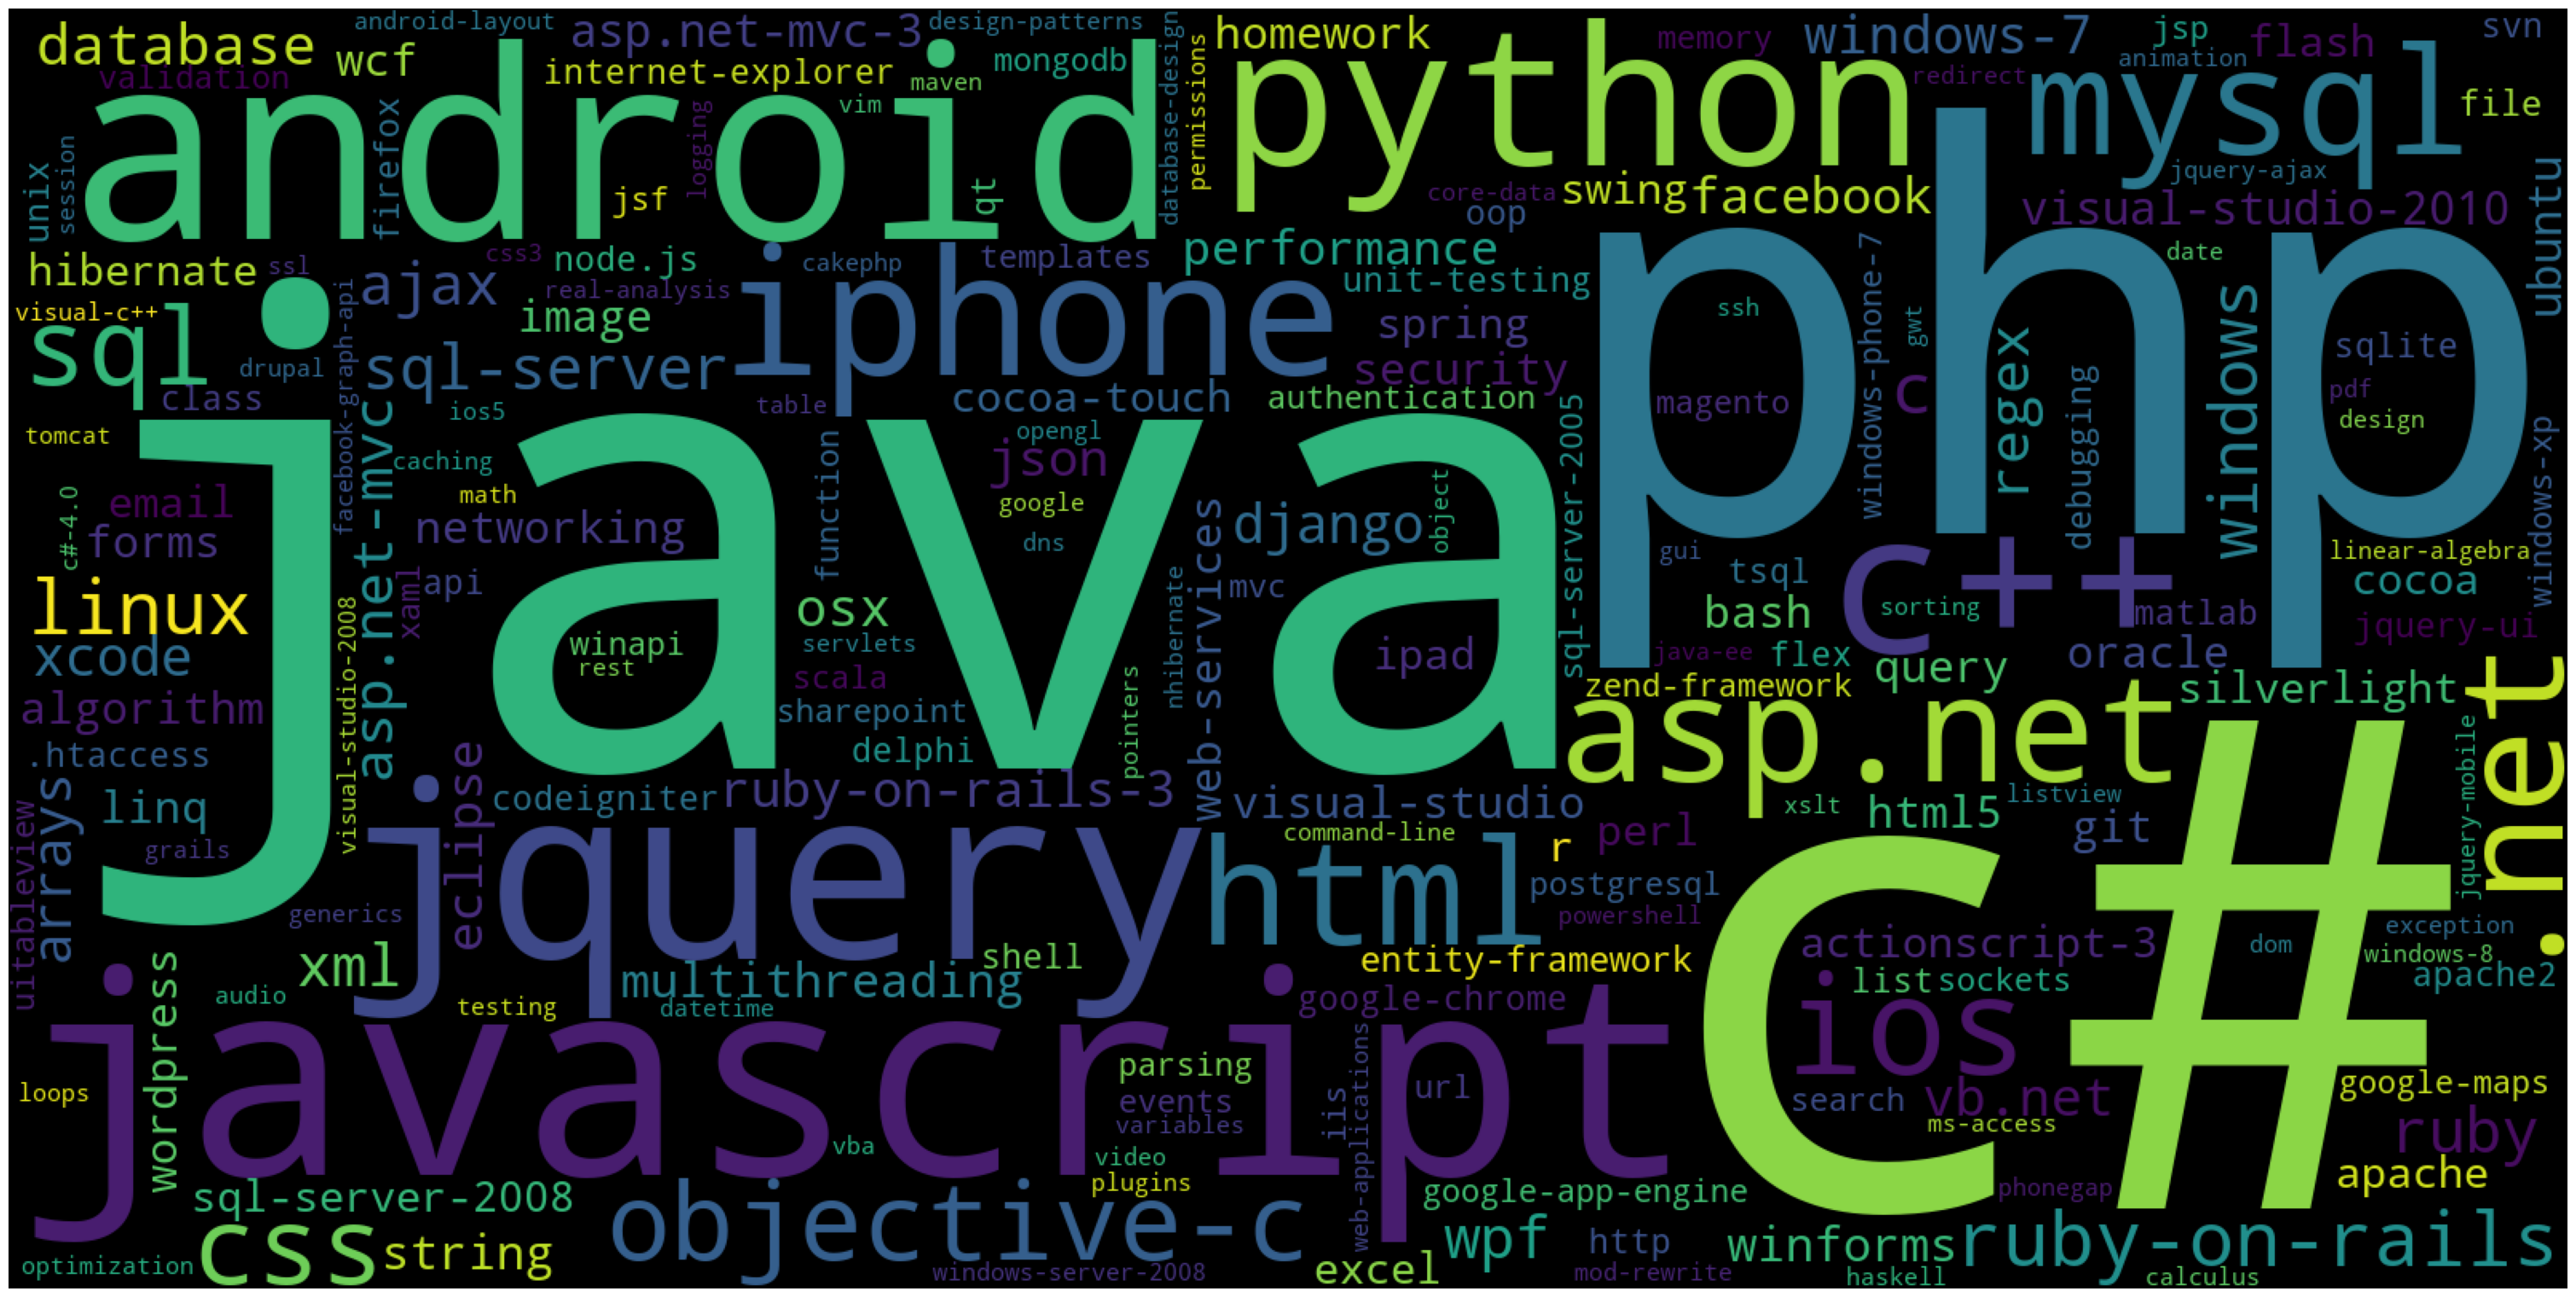

Time taken to run this cell : 0:00:02.086933


In [50]:
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
#tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(result)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

In [69]:
result.items()

dict_items([('.a', 18), ('.app', 37), ('.asp.net-mvc', 1), ('.aspxauth', 21), ('.bash-profile', 138), ('.class-file', 53), ('.cs-file', 14), ('.doc', 47), ('.drv', 1), ('.ds-store', 8), ('.each', 184), ('.emf', 33), ('.exe', 27), ('.exe.config', 1), ('.hgtags', 6), ('.htaccess', 14884), ('.htpasswd', 61), ('.ico', 10), ('.lib', 20), ('.lrc', 4), ('.mobi', 2), ('.mov', 16), ('.net', 114087), ('.net-1.0', 19), ('.net-1.1', 218), ('.net-2.0', 1661), ('.net-3.0', 55), ('.net-3.5', 3693), ('.net-4.0', 5020), ('.net-4.0-beta-2', 16), ('.net-4.0-rc1', 6), ('.net-4.5', 695), ('.net-assembly', 516), ('.net-authorization', 2), ('.net-bcl', 2), ('.net-bugs', 1), ('.net-cf-3.5', 61), ('.net-client-profile', 53), ('.net-compact', 1), ('.net-framework', 235), ('.net-framework-source', 15), ('.net-framework-version', 73), ('.net-gadgeteer', 12), ('.net-install', 7), ('.net-internals', 4), ('.net-interview', 3), ('.net-micro-framework', 103), ('.net-reflector', 24), ('.net-remoting', 126), ('.net-secu

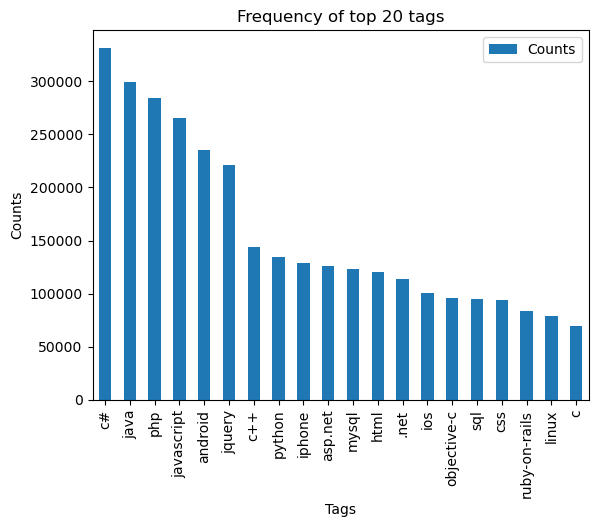

In [52]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'][:20])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [59]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [54]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [55]:
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 1:34:04.582058


In [61]:
nltk.download('punkt')
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mihirupadhyay/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1172
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57
Time taken to run this cell : 0:08:29.215270


In [85]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

ProgrammingError: Cannot operate on a closed database.

In [86]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("""SELECT question From QuestionsProcessed LIMIT 10""")
        print("questions after preprocessed")
        print("="*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print("_"*100)

conn_r.commit()
conn_r.close()

questions after preprocessed
('convert chm file singl html file tri mani differ chm html util difficult time find one abl produc singl html file decompil chm file use know easili merg result file singl html file preserv correct order page free tool merg html file order',)
____________________________________________________________________________________________________
('excel csv import treat quot string number numer valu string got web applic export data csv file one exampl row csv file question sinc post imag explain result excel field get turn number lead goe away get interpret one singl number obvious intend result seen peopl recommend lead singl quot case realli work either singl quot visibl time cell excel though enter number lead singl quot show intend string singl quot string import type seem anybodi solut',)
____________________________________________________________________________________________________
('get sate multipl checkbutton tkinter python write small tk python

In [93]:
print(write_db)

Processed.db


In [97]:
if os.path.isfile(write_db):
    conn = create_connection(write_db)
    if conn is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn)
conn.commit()
conn.close()

In [98]:
preprocessed_data.head()

,question,tags
0,form pass valu php want pass usernam valu dome...,php
1,convert chm file singl html file tri mani diff...,windows ebook chm
2,excel csv import treat quot string number nume...,microsoft-excel csv import string
3,get sate multipl checkbutton tkinter python wr...,python gui checkbox tkinter
4,visual studio macro list project instead solut...,visual-studio visual-studio-2010 vba visual-st...


In [99]:
preprocessed_data.shape

(999995, 2)

In [102]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [103]:
multilabel_y.shape

(999995, 35477)

In [104]:
type(multilabel_y)

scipy.sparse._csr.csr_matrix

In [130]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [131]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

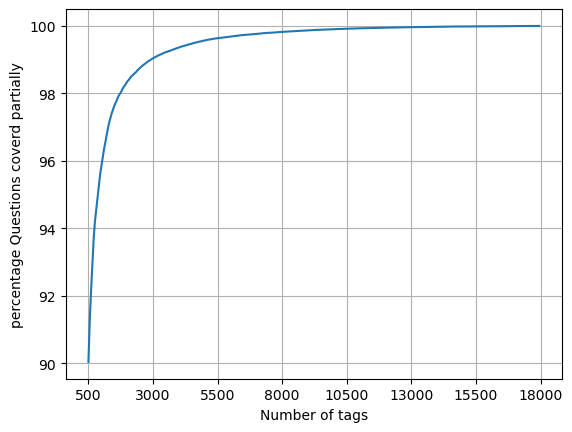

with  5500 tags we are covering  99.041 % of questions


In [133]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("percentage Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [134]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9594 out of  999995


In [135]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35477
number of tags taken : 5500 ( 15.503001944922062 %)


In [137]:
total_size = preprocessed_data.shape[0]
train_size = int(total_size * 0.80)

In [139]:
x_train = preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

In [147]:
y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799996, 5500)
Number of data points in test data : (199999, 5500)


In [148]:
y_train.shape

(799996, 5500)

In [149]:
x_train.shape

(799996, 2)

In [150]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:55:55.024595


In [151]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799996, 88020) Y : (799996, 5500)
Dimensions of test data X: (199999, 88020) Y: (199999, 5500)


In [155]:
import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl')

predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'